## General information

In this kernel I'll work with data from Quora Insincere Questions Classification Competition.

This dataset is interesting for NLP researching. We will try to find insincere questions which aren't usefull or are even harmful. I'll do a simple EDA and try an LSTM-CNN model. 

![](https://pbs.twimg.com/profile_images/1013607595616038912/pRq_huGc_400x400.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
import os
print(os.listdir("../input/embeddings/glove.840B.300d/"))

['glove.840B.300d.txt']


In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sub = pd.read_csv('../input/sample_submission.csv')

## Data overview

This is a kernel competition, where we can't use external data. As a result we can use only train and test datasets as well as embeddings which were provided by organizers.

In [4]:
import os
print('Available embeddings:', os.listdir("../input/embeddings/"))

Available embeddings: ['paragram_300_sl999', 'glove.840B.300d', 'wiki-news-300d-1M', 'GoogleNews-vectors-negative300']


In [5]:
train["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

We have a serious disbalance - only ~6% of data are positive. No wonder the metric for the competition is f1-score.

In [6]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In the dataset we have only texts of questions.

In [7]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [8]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [9]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


As we can see on average questions in train and test datasets are similar, but there are quite long questions in train dataset.

In [10]:
max_features = 90000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [11]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

Text(0.5,1,'Distribution of question text length in characters')

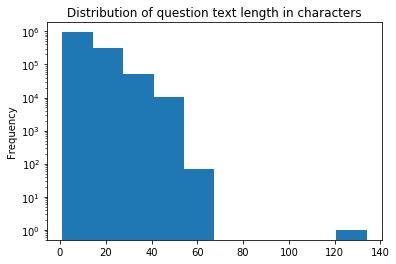

In [12]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

We can see that most of the questions are 40 words long or shorter. Let's try having sequence length equal to 70 for now.

In [13]:
max_len = 70
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [14]:
embedding_path = "../input/embeddings/glove.840B.300d/glove.840B.300d.txt"
#embedding_path = "../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt"

In [15]:
embed_size = 300

In [16]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(train['target'].values.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


For now I'll use an architecture from my previous [kernel](https://www.kaggle.com/artgor/movie-review-sentiment-analysis-eda-and-models) in another competition.

The architecture in the following:
- input with embedding;
- then we have separate "branches" - GRU and LSTM;
- each "branch" is processed by two Conv1D layers separately;
- each Conv1D layer has average and max pooling layers;
- all pooling layers are concatenated;
- two dense layers in the end;

In [18]:
def build_model(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [19]:
%%time
model = build_model(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=16, dr=0.1, conv_size=16, epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 300)      27000300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 70, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 70, 128)      140544      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [20]:
# pred = model.predict(X_test, batch_size = 1024, verbose = 1)
# predictions = np.round(np.argmax(pred, axis=1)).astype(int)
# sub['prediction'] = predictions
# sub.to_csv("submission.csv", index=False)

In [21]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)

    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [22]:
#model1 = build_model1(lr = 1e-4, lr_d = 1e-7, units = 128, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.3, conv_size=32, epochs=5)

In [23]:
#model1_1 = build_model1(lr = 1e-4, lr_d = 1e-7, units = 128, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=32, epochs=5)

In [24]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units * 2, return_sequences = True))(x1)
    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x_gru)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
  
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [25]:
#%%time
#model2 = build_model2(lr = 1e-4, lr_d = 1e-7, units = 256, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=32, epochs=5)

In [26]:
#model3 = build_model2(lr = 1e-3, lr_d = 1e-7, units = 256, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=16, epochs=5)

In [27]:
%%time
model4 = build_model2(lr = 1e-4, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=8, epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      27000300    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 70, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 70, 256)      330240      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [28]:
#model5 = build_model2(lr = 1e-4, lr_d = 1e-7, units = 256, spatial_dr = 0.1, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=16, epochs=5)

### Model with attention

https://github.com/Diyago/ML-DL-scripts/blob/9e161a96580efa9993805ca28f610df72fe36406/DEEP%20LEARNING/LSTM%20RNN/Sentiment%20analysis%20LSTM%20wth%20Bidirectional%20%20%2B%20Custom%20Attention.ipynb

In [29]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

### Attention

In [30]:
def build_model3(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, dense_units=128, dr=0.1, use_attention=True):
    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units * 2, return_sequences = True))(x1)
    if use_attention:
        x_att = Attention(max_len)(x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))
    else:
        x_att = Flatten() (x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))

    x = BatchNormalization()(x)
    #x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #model.summary()
    #history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
    #                    verbose = 1, callbacks = [check_point, early_stop])
    #model = load_model(file_path)
    return model

In [31]:
%%time
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
model6 = build_model3(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, dense_units=16, dr=0.1, use_attention=True)
history = model6.fit(X_train, y_ohe, batch_size = 512, epochs = 10, validation_split=0.1, 
                    verbose = 1, callbacks = [check_point, early_stop])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/10
1175509/1175509 [==============================] - 204s 174us/step - loss: 0.1703 - acc: 0.9376 - val_loss: 0.1184 - val_acc: 0.9540

Epoch 00001: val_loss improved from inf to 0.11836, saving model to best_model.hdf5
Epoch 2/10
1175509/1175509 [==============================] - 201s 171us/step - loss: 0.1212 - acc: 0.9531 - val_loss: 0.1125 - val_acc: 0.9559

Epoch 00002: val_loss improved from 0.11836 to 0.11252, saving model to best_model.hdf5
Epoch 3/10
1175509/1175509 [==============================] - 200s 170us/step - loss: 0.1159 - acc: 0.9546 - val_loss: 0.1101 - val_acc: 0.9570

Epoch 00003: val_loss improved from 0.11252 to 0.11013, saving model to best_model.hdf5
Epoch 4/10
1175509/1175509 [==============================] - 200s 170us/step - loss: 0.1120 - acc: 0.9558 - val_loss: 0.1081 - val_acc: 0.9567

Epoch 00004: val_loss improved from 0.11013 to 0.10810, saving model to best_model.hdf5
Epoch 5/10
1175509/

In [32]:
# #%%time
# file_path = "best_model.hdf5"
# check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
#                               save_best_only = True, mode = "min")
# early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
# model6_1 = build_model3(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, dense_units=16, dr=0.1, use_attention=False)
# history = model6_1.fit(X_train, y_ohe, batch_size = 512, epochs = 5, validation_split=0.1, 
#                     verbose = 1, callbacks = [check_point, early_stop])

### One branch

In [33]:
def build_model4(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
       
    x = concatenate([avg_pool1_gru, max_pool1_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    #x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [34]:
%%time
model7 = build_model4(lr = 1e-4, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=3, dense_units=32, dr=0.1, conv_size=8, epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 70, 300)      27000300    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 70, 300)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 70, 128)      140544      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
conv1d_7 (

In [35]:
#model8 = build_model4(lr = 1e-4, lr_d = 1e-7, units = 128, spatial_dr = 0.3, kernel_size1=4, dense_units=32, dr=0.1, conv_size=8, epochs=5)

### Masking

In [36]:
def build_model5(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)
    x_m = Masking()(x1)
    x_gru = LSTM(units)(x_m)

    x = BatchNormalization()(x_gru)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    #x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, reduce_lr])
    model = load_model(file_path)
    return model

In [37]:
#model9 = build_model5(lr = 1e-4, lr_d = 1e-7, units = 128, spatial_dr = 0.3, kernel_size1=4, dense_units=32, dr=0.1, conv_size=8, epochs=10)

In [38]:
pred1 = model.predict(X_test, batch_size = 1024, verbose = 1)
pred = pred1
pred4 = model4.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred4
pred2 = model7.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred2
# pred3 = model9.predict(X_test, batch_size = 1024, verbose = 1)
# pred += pred3
pred4 = model6.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred4
# pred5 = model7.predict(X_test, batch_size = 1024, verbose = 1)
# pred += pred5
pred = pred / 4

56370/56370 [==============================] - 4s 71us/step


In [39]:
#pred = model9.predict(X_test, batch_size = 1024, verbose = 1)

predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['prediction'] = predictions
sub.to_csv("submission.csv", index=False)